In [104]:
from __future__ import annotations

import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay,
)

from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.inspection import permutation_importance

import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

print("Artifacts dir:", ARTIFACTS_DIR.resolve())

Artifacts dir: C:\Users\danya\aie-course\aie-student-DDV\homeworks\HW06\artifacts


In [115]:
def compute_metrics(y_true, y_pred, y_proba=None) -> dict:
    m = {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "f1": float(f1_score(y_true, y_pred)),
    }
    if y_proba is not None:
        try:
            m["roc_auc"] = float(roc_auc_score(y_true, y_proba))
        except Exception:
            m["roc_auc"] = None
    else:
        m["roc_auc"] = None
    return m

def evaluate_on_test(model, X_test, y_test, label: str) -> dict:
    pred = model.predict(X_test)
    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]
    metrics = compute_metrics(y_test, pred, proba)
    metrics["model"] = label
    return metrics

def save_json(obj: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def plot_confusion(y_true, y_pred, title: str):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("pred")
    plt.ylabel("true")
    plt.xticks([0, 1])
    plt.yticks([0, 1])
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.savefig("artifacts/figures/confusion.png", dpi=300)
    plt.show()

def plot_roc(model, X_test, y_test, title: str):
    if not hasattr(model, "predict_proba"):
        print("ROC: модель не поддерживает predict_proba")
        return
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(title)
    plt.savefig("artifacts/figures/roc_curve.png", dpi=300)
    plt.show()

def plot_pr(model, X_test, y_test, title: str):
    if not hasattr(model, "predict_proba"):
        print("PR: модель не поддерживает predict_proba")
        return
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
    plt.title(title)
    plt.savefig("artifacts/figures/pr_curve.png", dpi=300)
    plt.show()
     

In [59]:
file = 'S06-hw-dataset-04.csv'
data = pd.read_csv(file, sep=",")

In [60]:
data.head(10)

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f52,f53,f54,f55,f56,f57,f58,f59,f60,target
0,1,-1.250210,1.423474,-0.225004,-4.023138,-0.832729,-0.550874,1.772090,2.761690,-0.698750,...,10.938269,0.501178,1.600001,0.314212,1.209735,1.355697,-5.338924,1.153944,-0.153934,0
1,2,0.074328,0.376429,0.212831,-0.502074,2.017405,0.625496,1.943785,1.242030,-0.524090,...,7.775262,-4.550195,6.272586,-0.932162,-0.228543,1.735220,-3.827828,0.292165,0.273720,0
2,3,0.638481,0.060968,0.746760,2.479653,-0.292858,-0.078139,-2.918423,-0.013186,1.009135,...,-4.448447,-9.593179,-3.093519,0.029321,0.605511,0.829103,-0.085985,2.891408,0.766221,0
3,4,1.712916,-1.350969,-0.256473,1.622074,-0.445141,0.911932,-3.440345,1.505192,-1.104348,...,-1.619072,-3.237479,-5.474038,-1.582475,0.198137,3.823409,0.880395,1.148610,0.136732,0
4,5,0.905676,-0.206545,-0.068806,4.086026,-1.010045,-0.772644,-4.207688,2.506104,1.589143,...,-2.396844,-10.540129,-5.532811,-1.231203,0.000119,4.298572,-1.558235,0.924673,0.111668,0
5,6,0.351616,0.481730,-0.059426,-6.162660,-0.904385,1.039488,3.526690,-1.936008,-1.271015,...,-6.899112,-4.244255,3.618382,0.390679,-1.078302,-1.596711,0.960976,-0.696109,0.789843,0
6,7,0.009556,-0.302245,1.758107,2.387949,-0.159018,0.513037,-2.030979,0.233601,-0.613787,...,1.795449,-4.214136,3.547422,1.671520,1.328784,0.989936,-3.239148,-0.126460,0.207136,0
7,8,0.399209,-0.858872,-1.246342,4.408661,0.591843,0.692164,-3.598279,4.740219,-0.373844,...,3.435654,-8.506978,0.600471,-1.453072,0.970110,5.088251,-4.195527,-1.670106,0.088272,0
8,9,1.501108,0.242817,-0.288667,5.698227,1.957273,-0.398468,-0.030115,-1.337939,1.150275,...,-6.088357,-11.925756,10.761279,0.617478,0.795555,3.808274,0.585404,1.740210,0.274570,0
9,10,1.039334,-0.994914,-0.834382,-1.633916,-0.378813,-1.316047,1.288036,3.016957,0.252401,...,4.856000,-0.736908,-1.586639,0.260909,0.384358,-0.646923,-1.469907,0.205919,0.964375,0


In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 62 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      25000 non-null  int64  
 1   f01     25000 non-null  float64
 2   f02     25000 non-null  float64
 3   f03     25000 non-null  float64
 4   f04     25000 non-null  float64
 5   f05     25000 non-null  float64
 6   f06     25000 non-null  float64
 7   f07     25000 non-null  float64
 8   f08     25000 non-null  float64
 9   f09     25000 non-null  float64
 10  f10     25000 non-null  float64
 11  f11     25000 non-null  float64
 12  f12     25000 non-null  float64
 13  f13     25000 non-null  float64
 14  f14     25000 non-null  float64
 15  f15     25000 non-null  float64
 16  f16     25000 non-null  float64
 17  f17     25000 non-null  float64
 18  f18     25000 non-null  float64
 19  f19     25000 non-null  float64
 20  f20     25000 non-null  float64
 21  f21     25000 non-null  float64
 22

In [62]:
data.describe()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f52,f53,f54,f55,f56,f57,f58,f59,f60,target
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,...,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000
mean,12500.500000,-0.000386,-0.004872,0.003202,0.335329,-0.000563,-0.010118,0.001182,0.957385,-0.004658,...,-0.166251,-3.387506,1.749793,-0.013017,-0.001383,0.893365,-0.909479,0.000570,-0.000754,0.04920
std,7217.022701,1.001623,0.995606,1.004367,3.207537,0.993965,1.002172,2.432162,1.830223,1.013470,...,4.234741,4.331576,5.318660,1.001594,0.996409,2.445185,1.962618,0.994320,0.997167,0.21629
min,1.000000,-4.370993,-4.087073,-4.103875,-13.249937,-4.118778,-3.895974,-8.883224,-8.132548,-4.068933,...,-20.021141,-18.332290,-20.336666,-4.349216,-4.119472,-9.508509,-7.919287,-4.038312,-3.812255,0.00000
25%,6250.750000,-0.680165,-0.675100,-0.675426,-1.750048,-0.669764,-0.674374,-1.647977,-0.217260,-0.688278,...,-2.897904,-6.278403,-1.775889,-0.689962,-0.676191,-0.735473,-2.226959,-0.666367,-0.665861,0.00000
50%,12500.500000,0.001859,-0.000247,0.013272,0.403483,-0.001309,-0.005994,-0.011349,0.963009,0.000414,...,-0.396946,-3.462072,1.931851,-0.020933,-0.004193,0.888535,-0.923354,0.004381,0.002420,0.00000
75%,18750.250000,0.679702,0.659523,0.683437,2.486453,0.672299,0.652629,1.658680,2.167758,0.681040,...,2.344956,-0.578540,5.473886,0.661300,0.673722,2.516790,0.395648,0.666474,0.665918,0.00000
max,25000.000000,4.208888,3.984564,3.793442,15.288250,4.020733,4.279607,9.538525,9.321099,4.261349,...,20.717964,18.818764,20.688069,4.338337,3.902131,11.880651,6.778980,3.834922,4.012639,1.00000


In [63]:
data['target'].value_counts(normalize=True)

target
0    0.9508
1    0.0492
Name: proportion, dtype: float64

Через data.info() видно, что исходный датасет не имеет пропусков по столбцам (25000 из 25000), также 2 столбца имеют значения int, остальные float

In [111]:
X = data.drop(columns=['id', 'target'])
y = data['target']


In [65]:
X

,f01,f02,f03,f04,f05,f06,f07,f08,f09,f10,...,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60
0,-1.250210,1.423474,-0.225004,-4.023138,-0.832729,-0.550874,1.772090,2.761690,-0.698750,-1.857165,...,1.130519,10.938269,0.501178,1.600001,0.314212,1.209735,1.355697,-5.338924,1.153944,-0.153934
1,0.074328,0.376429,0.212831,-0.502074,2.017405,0.625496,1.943785,1.242030,-0.524090,-0.009307,...,-0.311057,7.775262,-4.550195,6.272586,-0.932162,-0.228543,1.735220,-3.827828,0.292165,0.273720
2,0.638481,0.060968,0.746760,2.479653,-0.292858,-0.078139,-2.918423,-0.013186,1.009135,-4.966481,...,-1.159370,-4.448447,-9.593179,-3.093519,0.029321,0.605511,0.829103,-0.085985,2.891408,0.766221
3,1.712916,-1.350969,-0.256473,1.622074,-0.445141,0.911932,-3.440345,1.505192,-1.104348,0.291916,...,0.662697,-1.619072,-3.237479,-5.474038,-1.582475,0.198137,3.823409,0.880395,1.148610,0.136732
4,0.905676,-0.206545,-0.068806,4.086026,-1.010045,-0.772644,-4.207688,2.506104,1.589143,-0.849466,...,1.245923,-2.396844,-10.540129,-5.532811,-1.231203,0.000119,4.298572,-1.558235,0.924673,0.111668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.365760,0.415970,-2.011062,-5.371130,-1.308558,-0.563970,5.201922,-3.499144,-0.060352,6.305022,...,-0.801519,-1.929263,-8.680673,15.047120,-0.143813,0.516291,0.823833,-4.224887,-1.587583,0.771520
24996,-0.149945,0.333374,0.376841,1.034450,-0.675257,-0.918264,-0.852997,0.807168,0.608834,-1.938881,...,-1.633939,-2.703597,-7.164746,3.283665,-0.992620,-0.238159,0.529495,-2.853572,0.095721,0.187521
24997,1.126695,-0.337465,-0.025865,1.120373,0.926596,1.376231,-1.477048,1.198022,-0.127361,-6.842055,...,0.779228,-3.340906,-12.411586,4.887072,2.282438,-0.802952,3.094978,-5.014264,-0.580568,-0.226469
24998,0.573838,-0.546452,-1.155111,4.362236,0.179052,0.842566,0.755143,0.002815,0.015477,1.724121,...,-0.111896,-4.822115,-10.745787,3.098257,-1.255395,0.186830,3.303343,2.933538,0.585642,-0.989008


In [66]:
y

0        0
1        0
2        0
3        0
4        0
        ..
24995    0
24996    0
24997    0
24998    0
24999    1
Name: target, Length: 25000, dtype: int64

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y
)

X_train.shape, X_test.shape

((18750, 60), (6250, 60))

Фиксированный seed важен для воспроизводимости эксперимента, а стратификация необходима для учета дисбаланса классов (и в тренировачной, и в тестовой выборке будет одинаковая пропорция данных target (95% - 0 и 5% - 1))

In [73]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = []
best_models = {} 
search_summaries = {}

dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
results.append(evaluate_on_test(dummy, X_test, y_test, "Dummy(most_frequent)"))
best_models["Dummy(most_frequent)"] = dummy

lr = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=4000, random_state=RANDOM_STATE, l1_ratio=0))
])

lr_grid = {
    "lr__C": [0.1, 1.0, 10.0],
    "lr__solver": ["lbfgs"],
}

lr_search = GridSearchCV(
    lr, lr_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)
lr_search.fit(X_train, y_train)

best_lr = lr_search.best_estimator_
best_models["LogReg(scaled)"] = best_lr

search_summaries["LogReg(scaled)"] = {
    "best_params": lr_search.best_params_,
    "best_cv_roc_auc": float(lr_search.best_score_),
}

results.append(evaluate_on_test(best_lr, X_test, y_test, "LogReg(scaled)"))

search_summaries["LogReg(scaled)"]

{'best_params': {'lr__C': 0.1, 'lr__solver': 'lbfgs'},
 'best_cv_roc_auc': 0.820248855339833}

In [74]:
results

[{'accuracy': 0.95088,
  'f1': 0.0,
  'roc_auc': 0.5,
  'model': 'Dummy(most_frequent)'},
 {'accuracy': 0.96256,
  'f1': 0.4090909090909091,
  'roc_auc': 0.8400411948253248,
  'model': 'LogReg(scaled)'}]

Baseline – это “точка отсчёта”. Если модель не обгоняет baseline, то:
- a) Она не подходит под задачу,
- б) Неправильно настроили эксперимент (например, переобучили/недообучили).

Два baseline’а:
- DummyClassifier(most_frequent) – простейшая нижняя планка (угадываем самый частый класс).
- LogisticRegression – сильный и быстрый baseline из прошлой недели (линейная модель + нормировка признаков).

Dummy угадывает с точностью 95.088% (Угадывает значение target = 0), но Значение AUC 0,5 указывает на отсутствие дискриминационной способности модели, то есть на случайное угадывание. f1 = 0, говорит о том, что классификатор не может угадать значение 1

LogReg угадывает с точностью 96.256%. Значение roc_auc = 0.84, что говорит о приближении к хорошей классификации (Чем ближе к 1 тем лучше классификатор). f1 - важная для нас метрика, так как в датасете имеется дисбаланс классов, а этот параметр хорошо показывает при таких данных


In [75]:
def run_search(label: str, estimator, param_grid: dict):
    search = GridSearchCV(
        estimator,
        param_grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        refit=True,
        return_train_score=True
    )
    search.fit(X_train, y_train)

    best = search.best_estimator_
    best_models[label] = best
    search_summaries[label] = {
        "best_params": search.best_params_,
        "best_cv_roc_auc": float(search.best_score_),
    }
    results.append(evaluate_on_test(best, X_test, y_test, label))
    return search

In [133]:
dt = DecisionTreeClassifier(random_state=5000)

dt_grid = {
    "max_depth": [None, 3, 5, 8],
    "min_samples_leaf": [1, 5, 10, 20],
    "ccp_alpha": [0.0, 0.001, 0.005, 0.01],
}

dt_search = run_search("DecisionTree", dt, dt_grid)
search_summaries["DecisionTree"]

{'best_params': {'ccp_alpha': 0.0, 'max_depth': 8, 'min_samples_leaf': 20},
 'best_cv_roc_auc': 0.7953116096498518}

In [79]:
rf = RandomForestClassifier(
    n_estimators=600,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    oob_score=False
)

rf_grid = {
    "max_depth": [None, 6, 10],
    "min_samples_leaf": [1, 5, 10],
    "max_features": ["sqrt", 0.5],
}

rf_search = run_search("RandomForest", rf, rf_grid)
search_summaries["RandomForest"]

{'best_params': {'max_depth': None,
  'max_features': 'sqrt',
  'min_samples_leaf': 5},
 'best_cv_roc_auc': 0.8846524269780405}

In [80]:
hgb = HistGradientBoostingClassifier(
    random_state=RANDOM_STATE,
    early_stopping=True
)

hgb_grid = {
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [2, 3, None],
    "max_leaf_nodes": [15, 31, 63],
}

hgb_search = run_search("HistGradientBoosting", hgb, hgb_grid)
search_summaries["HistGradientBoosting"]

{'best_params': {'learning_rate': 0.05,
  'max_depth': None,
  'max_leaf_nodes': 63},
 'best_cv_roc_auc': 0.8962365852219099}

In [126]:
estimators = [
    ("lr", best_models["LogReg(scaled)"]),
    ("rf", best_models["RandomForest"]),
    ("hgb", best_models["HistGradientBoosting"]),
]

stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=4000, random_state=RANDOM_STATE),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

stack.fit(X_train, y_train)
best_models["Stacking"] = stack
results.append(evaluate_on_test(stack, X_test, y_test, "Stacking"))

{"note": "stacking fitted"}

{'note': 'stacking fitted'}

In [134]:
df = pd.DataFrame(results)

df_sorted = df.copy()
df_sorted["roc_auc_sort"] = df_sorted["roc_auc"].fillna(-1.0)
df_sorted = df_sorted.sort_values(["roc_auc_sort", "accuracy"], ascending=False).drop(columns=["roc_auc_sort"])

df_sorted

,accuracy,f1,roc_auc,model
5,0.98160,0.776699,0.906037,Stacking
6,0.98160,0.776699,0.906037,Stacking
7,0.98160,0.776699,0.906037,Stacking
8,0.98160,0.776699,0.906037,Stacking
9,0.98160,0.776699,0.906037,Stacking
10,0.98160,0.776699,0.906037,Stacking
4,0.97984,0.742857,0.904646,HistGradientBoosting
3,0.97024,0.567442,0.903547,RandomForest
1,0.96256,0.409091,0.840041,LogReg(scaled)
2,0.96848,0.588727,0.827972,DecisionTree


In [92]:
metrics_path = ARTIFACTS_DIR / "metrics_test.json"
search_path = ARTIFACTS_DIR / "search_summaries.json"

save_json({"results": df_sorted.to_dict(orient="records")}, metrics_path)
save_json(search_summaries, search_path)

print("Saved:", metrics_path)
print("Saved:", search_path)

Saved: artifacts\metrics_test.json
Saved: artifacts\search_summaries.json


In [93]:
best_row = df_sorted.iloc[0]
best_label = best_row["model"]
best_model = best_models[best_label]

best_label, best_row.to_dict()

('Stacking',
 {'accuracy': 0.9816,
  'f1': 0.7766990291262136,
  'roc_auc': 0.9060373219855731,
  'model': 'Stacking'})

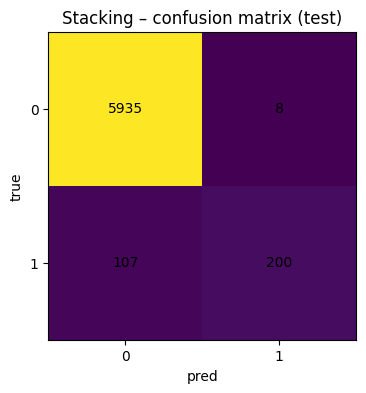

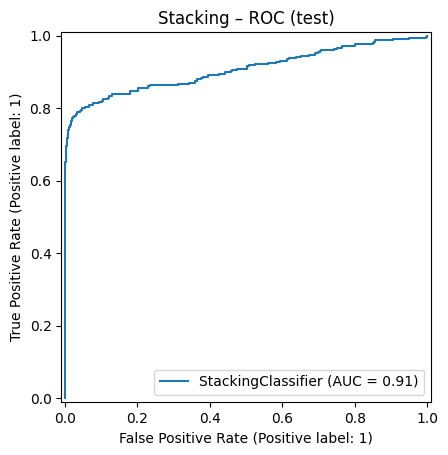

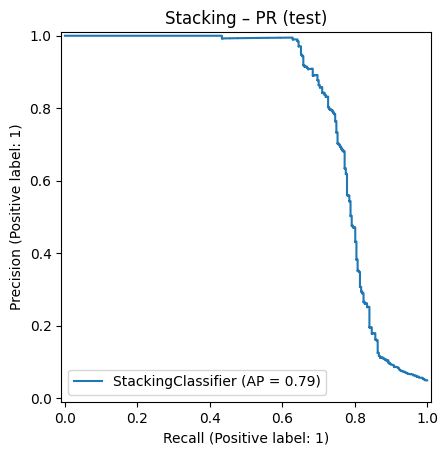

In [116]:
y_pred = best_model.predict(X_test)
plot_confusion(y_test, y_pred, title=f"{best_label} – confusion matrix (test)")
plot_roc(best_model, X_test, y_test, title=f"{best_label} – ROC (test)")
plot_pr(best_model, X_test, y_test, title=f"{best_label} – PR (test)" )


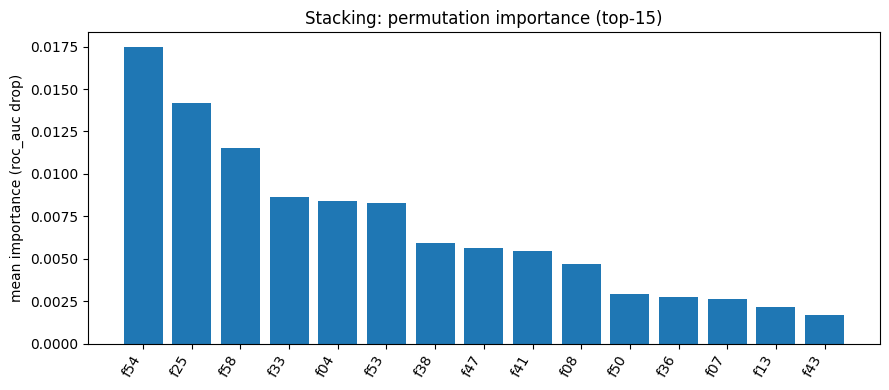

In [113]:
feature_names = X.columns.tolist()

scoring = "roc_auc" if hasattr(best_model, "predict_proba") else "accuracy"

perm = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=8,
    random_state=RANDOM_STATE,
    scoring=scoring
)

imp = perm.importances_mean
idx = np.argsort(imp)[::-1][:15]

plt.figure(figsize=(9, 4))
plt.bar(range(len(idx)), imp[idx])
plt.xticks(range(len(idx)), [feature_names[i] for i in idx], rotation=60, ha="right")
plt.ylabel(f"mean importance ({scoring} drop)")
plt.title(f"{best_label}: permutation importance (top-15)")
plt.tight_layout()
plt.show()

Permutation importance отвечает на вопрос:

“Если случайно перемешать один признак, насколько сильно ухудшится качество модели?”

Если качество падает сильно – признак важен. Если почти не меняется – признак малозначим (для этой модели и этой метрики).

Самые важные признаки, которые  удалось выявить: f54, f25, f58, f33, f04, f53, f38, f47, f41, f08, f50, f36, f07, f13, f43

Признак f54 доминирует - его перемешивание снижает ROC-AUC почти на 1.75%, что говорит о его критической роли в прогнозировании целевой переменной.

Также сильно влияют f25, f58 - перемешивание снижает ROC-AUC ~0.014 и ~0.011

Следом идет группы признаков (f33, f04, f53), (f38, f47, f41, f08), (f50, f36, f07, f13, f43)  - по значимости примерно равны между собой, вероятно группы описывают схожие свойства

Модель не переобучена на шум — большинство признаков имеют низкую важность.

In [117]:
model_path = ARTIFACTS_DIR / "best_model.joblib"
joblib.dump(best_model, model_path)

meta = {
    "best_model_label": best_label,
    "test_metrics": best_row.to_dict(),
    "search_summary": search_summaries.get(best_label, None),
    "random_state": RANDOM_STATE,
}
save_json(meta, ARTIFACTS_DIR / "best_model_meta.json")

print("Saved:", model_path)
print("Saved:", ARTIFACTS_DIR / "best_model_meta.json")

Saved: artifacts\best_model.joblib
Saved: artifacts\best_model_meta.json
